In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve

In [2]:
# read data into variables
gt = pd.read_excel('dataInfo.xlsx', usecols=[2,3,4,5])
imagePreds = pd.read_csv('image_predictions.csv')
heatmapPreds = pd.read_csv('imageheatmaps_predictions.csv')
gt

,View,Side,Status,Tumour_Contour
0,CC,LEFT,Normal,-
1,MLO,LEFT,Normal,-
2,CC,RIGHT,Normal,-
3,MLO,RIGHT,Normal,-
4,CC,LEFT,Normal,-
...,...,...,...,...
7803,MLO,RIGHT,Normal,-
7804,CC,LEFT,Normal,-
7805,MLO,LEFT,Normal,-
7806,CC,RIGHT,Normal,-


In [3]:
# map string values into correspond integer values
pd.options.display.max_rows = 4000
mapping = {'Normal': 0, 'Benign': 1, 'Cancer': 2}
gtNum = gt.replace({'Status': mapping})

# format gt properly
benignGt = pd.DataFrame(np.zeros(imagePreds.shape[0]*2))
malignantGt = benignGt.copy()

for index, row in benignGt.iterrows():
    # left goes in indexes, right goes in odd
    if ( index % 2 == 0):
        if (gtNum.iloc[index*2][2] == 1 or gtNum.iloc[index*2+1][2] == 1):
            # check for masks (no mask = normal)
            if gtNum.iloc[index*2][3] != '-' or gtNum.iloc[index*2+1][3] != '-':
                row[0] = 1
    else:
        if (gtNum.iloc[index*2][2] == 1 or gtNum.iloc[index*2+1][2] == 1):
            # check for masks (no mask = normal)
            if gtNum.iloc[index*2][3] != '-' or gtNum.iloc[index*2+1][3] != '-':
                row[0] = 1
        
for index, row in malignantGt.iterrows():
    # check if malignant
    # left goes in even indexes, right goes in odd
    if ( index % 2 == 0):
        if (gtNum.iloc[index*2][2] == 2 or gtNum.iloc[index*2+1][2] == 2):
             # check for masks (no mask = normal)
            if gtNum.iloc[index*2][3] != '-' or gtNum.iloc[index*2+1][3] != '-':
                row[0] = 1
                
    else:
        if (gtNum.iloc[index*2][2] == 2 or gtNum.iloc[index*2+1][2] == 2):
            # check for masks (no mask = normal)
            if gtNum.iloc[index*2][3] != '-' or gtNum.iloc[index*2+1][3] != '-':
                row[0] = 1


In [4]:
# helper to assign values based on predictions

def predictLabels(inputPreds, thresh):
    dummyInput = inputPreds.copy()
    for index, row in dummyInput.iterrows():
        # left benign
        if ( row[0] > thresh ):
            row[0] = 1
        else:
            row[0] = 0

        # right benign    
        if ( row[1] > thresh ):
            row[1] = 1
        else:
            row[1] = 0

        # left malignant    
        if ( row[2] > thresh):
            row[2] = 1
        else:
            row[2] = 0

        # right malignant    
        if ( row[3] > thresh):
            row[3] = 1
        else:
            row[3] = 0
            
    return dummyInput

AUC:
Image (Benign):  0.6057156441931881
Heatmap (Benign):  0.5737500436208822
Image (Malignant):  0.6206175043564425
Heatmap (Malignant):  0.7525354921925718


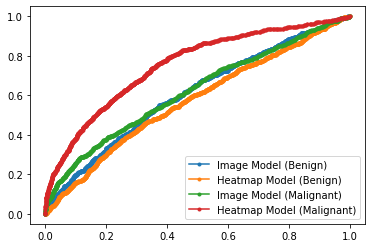

In [5]:
# calculate AUC
image_b_preds = pd.DataFrame(np.zeros(imagePreds.shape[0]*2))
heat_b_preds = image_b_preds.copy()
image_m_preds = image_b_preds.copy()
heat_m_preds = image_b_preds.copy()

#benign classifications
for index, row in image_b_preds.iterrows():
    # left goes in even indexes, right goes in odd
    if ( index % 2 == 0):
        row[0] = imagePreds.iloc[index//2][0]
    else:
        row[0] = imagePreds.iloc[index//2][1]
        
for index, row in heat_b_preds.iterrows():
    # left goes in even indexes, right goes in odd
    if ( index % 2 == 0):
        row[0] = heatmapPreds.iloc[index//2][0]
    else:
        row[0] = heatmapPreds.iloc[index//2][1]
        
# malignant classifications
for index, row in image_m_preds.iterrows():
    # left goes in even indexes, right goes in odd
    if ( index % 2 == 0):
        row[0] = imagePreds.iloc[index//2][2]
    else:
        row[0] = imagePreds.iloc[index//2][3]
            
for index, row in heat_m_preds.iterrows():
    # left goes in even indexes, right goes in odd
    if ( index % 2 == 0):
        row[0] = heatmapPreds.iloc[index//2][2]
    else:
        row[0] = heatmapPreds.iloc[index//2][3]

print('AUC:')
fpr, tpr, thresholds = roc_curve(benignGt, image_b_preds)
auc = roc_auc_score(benignGt, image_b_preds)
plt.plot(fpr, tpr, marker='.', label='Image Model (Benign)')
print('Image (Benign): ',auc)

fpr, tpr, thresholds = roc_curve(benignGt, heat_b_preds)
auc = roc_auc_score(benignGt, heat_b_preds)
plt.plot(fpr, tpr, marker='.', label='Heatmap Model (Benign)')
print('Heatmap (Benign): ',auc)

fpr, tpr, thresholds = roc_curve(malignantGt, image_m_preds)
auc = roc_auc_score(malignantGt, image_m_preds)
plt.plot(fpr, tpr, marker='.', label='Image Model (Malignant)')
print('Image (Malignant): ',auc)

fpr, tpr, thresholds = roc_curve(malignantGt, heat_m_preds)
auc = roc_auc_score(malignantGt, heat_m_preds)
plt.plot(fpr, tpr, marker='.', label='Heatmap Model (Malignant)')
plt.legend(loc='best')
print('Heatmap (Malignant): ',auc)
